## LuTan-1 interferometric processing

Credits: Junfeng Li focused the raw radar echo into SLC, Qingyue Yang coregistered the SLC pair and generated the interferogram. Both are from the Aerospace Information Research Institute, Chinese Academy of Sciences (AIRCAS).

Relevant links:
+ Urgent response from CASC: https://mp.weixin.qq.com/s/SuFf4t91nyfaQo6CXC-QuQ

In [5]:
%matplotlib inline
import os
import platform
import shutil
import numpy as np
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from mintpy.objects import conncomp, sensor
from mintpy.utils import ptime, readfile, writefile, isce_utils, utils as ut, plot as pp
from mintpy.cli import geocode, mask, subset, view
from skimage import measure
from skimage.transform import resize
plt.rcParams.update({'font.size': 12})

if platform.system() == 'Linux':
    proj_dir = os.path.expanduser('~/data/2023TurkeyEQ')
else:
    proj_dir = os.path.expanduser('~/data/archives/2023TurkeyEQ')
data_dir = os.path.join(proj_dir, 'SAR/LT1_D068/SLCprocess2')
work_dir = os.path.join(proj_dir, 'LT1_D068_20220411_20230210')
os.chdir(work_dir)
print('Go to directory:', work_dir)

dname = os.path.basename(work_dir)

# input / output files
geom_file = os.path.join(work_dir, 'inputs/geometryGeo.h5')
int_file = os.path.join(work_dir, 'filt_fine.int')
cor_file = os.path.join(work_dir, 'filt_fine.cor')
msk_file = os.path.join(work_dir, 'filt_fine.msk')
unw_file = os.path.join(work_dir, 'filt_fine.unw')
conncomp_file = os.path.join(work_dir, 'filt_fine.unw.conncomp')

meta_file = os.path.join(data_dir, 'A_B.diff.rsc')     # metadata file for the pair, including platform info
dem_file = os.path.join(proj_dir, 'DEM/demLat_N35_N42_Lon_E034_E041_90m.h5')
flt_file = os.path.join(proj_dir, 'USGS/simple_fault_confident.lonlat')

Go to directory: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210


In [11]:
def get_nonzero_row_number(data, buffer=2):
    """Find the first and last row number of rows without zero value
    for multiple swaths data

    Copied from mintpy.utils.isce_utils.extract_geometry_metadata.get_nonzero_row_number()
    """ 
    if np.all(data):
        r0, r1 = 0 + buffer, -1 - buffer
    else:
        row_flag = np.sum(data != 0., axis=1) > 0
        row_idx = np.where(row_flag)[0] 
        r0, r1 = row_idx[0] + buffer, row_idx[-1] - buffer
    return r0, r1


def generate_mask4earthquake_rupture(gmt_lonlat_files, int_file, msk_file, lookup_file, rupture_width=20, ymax=None):
    """Generate mask for earthquake ruptures, to facilitae the phase unwrapping of co-seismic deformation.

    Parameters: rupture_files - list(str), path to the text file of rupture traces in GMT lonlat format
                int_file      - str, path to the interferogram
                msk_file      - str, path to the output mask file
                lookup_file   - list(str), path to the lookup table files, e.g.:
                                'geometryRadar.h5', or 
                                ['lat.rdr', 'lon.rdr']
                rupture_width - int, surface rupture width in pixels
                ymax          - int, maximum y/row index, to trim out some abnormal results.
                                Probably due to the design flaw of mintpy.objects.coord.coordinate class.
    Returns:    msk_file      - str, path to the output mask file
    """
    work_dir = os.path.dirname(os.path.abspath(int_file))
    # go to work directory
    os.chdir(work_dir)
    print('Go to directory:', work_dir)

    # read EQ rupture trace files
    faults_lola = []
    for gmt_lonlat_file in gmt_lonlat_files:
        print(f'read fault lat/lon from file: {gmt_lonlat_file}')
        faults_lola += readfile.read_gmt_lonlat_file(gmt_lonlat_file, min_dist=0)

    # translate lat/lon into local X/Y coordinates
    atr = readfile.read_attribute(int_file)
    coord = ut.coordinate(atr, lookup_file=lookup_file)
    faults_xy = []
    num_fault = len(faults_lola)
    print('translating lat/lon into local X/Y coordiantes...')
    prog_bar = ptime.progressBar(maxValue=num_fault)
    for i, fault_lola in enumerate(faults_lola):
        prog_bar.update(i+1, suffix=f'fault {i+1}/{num_fault} ({fault_lola.shape[0]} points)')
        # translate point-by-point to keep faults with partial points outside of the coverage
        fault_xy = []
        for j in range(fault_lola.shape[0]):
            try:
                y, x, y_std, x_std = coord.geo2radar(fault_lola[j,1], fault_lola[j,0])
                if ymax and y > ymax:
                    pass
                else:
                    fault_xy.append((x, y))
            except:
                pass
        if fault_xy:
            faults_xy.append(fault_xy)
    prog_bar.close()

    # rasterize
    # link: https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html
    print(f'rasterize local X/Y coordiantes with a width of {rupture_width} pixels')
    length, width = int(atr['LENGTH']), int(atr['WIDTH'])
    img = Image.new('L', (int(width), int(length)), 1)
    for i, fault_xy in enumerate(faults_xy):
        ImageDraw.Draw(img).line(fault_xy, fill=0, width=rupture_width, joint='curve')
    msk = np.array(img, dtype=np.bool_)

    # write to file
    meta = dict(atr)
    meta['FILE_TYPE'] = '.msk'
    meta['DATA_TYPE'] = 'bool'
    meta['BANDS'] = 1
    writefile.write(msk, out_file=msk_file, metadata=meta, ref_file=int_file)
    print(f'write mask to file: {msk_file}')

    # plot
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12, 6])
    ax = axs[0]
    for i, fault in enumerate(faults_lola):
        ax.plot(fault[:,0], fault[:,1], label=i+1)
    ax.set_aspect('equal')
    ax.legend(ncol=3)
    ax = axs[1]
    im = ax.imshow(msk, cmap='gray', interpolation='nearest')
    pp.auto_flip_direction(atr, ax=ax)
    fig.colorbar(im, ax=ax, shrink=0.5)
    plt.show()

    return msk_file


def filter_goldstein(infile, outfile, filt_strength=0.2):
    import isce
    import isceobj
    from mroipac.filter.Filter import Filter
    print("Applying power-spectral filter")

    # Initialize the flattened interferogram
    intImage = isceobj.createIntImage()
    intImage.load(infile + '.xml')
    intImage.setAccessMode('read')
    intImage.createImage()

    # Create the filtered interferogram
    filtImage = isceobj.createIntImage()
    filtImage.setFilename(outfile)
    filtImage.setWidth(intImage.getWidth())
    filtImage.setAccessMode('write')
    filtImage.createImage()

    objFilter = Filter()
    objFilter.wireInputPort(name='interferogram',object=intImage)
    objFilter.wireOutputPort(name='filtered interferogram',object=filtImage)
    objFilter.goldsteinWerner(alpha=filt_strength)

    intImage.finalizeImage()
    filtImage.finalizeImage()
    return outfile


print('warm up utils functioins.')

warm up utils functioins.


### 1. Prepare interferogram

(Stitch segments -->) convert from gamma to isce2 format --> filter

#### [obsolete] 1.1 stitch multiple segments from focusing into one

In [113]:
seg_files = [os.path.join(data_dir, f'seg{x}/B_A.diff') for x in range(1,9)]
atr = readfile.read_roipac_rsc(meta_file)
length, width = int(atr['LENGTH']), int(atr['WIDTH'])

In [114]:
coh = np.zeros((length, width), dtype=np.float32)
pha = np.zeros((length, width), dtype=np.float32)
for seg_file in seg_files:
    if not os.path.isfile(seg_file + '.rsc'):
        shutil.copy2(meta_file, os.path.dirname(seg_file))

    print(f'stitching file {seg_file}')
    coh_data = readfile.read(seg_file, datasetName='magnitude')[0]
    pha_data = readfile.read(seg_file, datasetName='phase')[0]
    r0, r1 = get_nonzero_row_number(coh_data)
    coh[r0:r1,:] = coh_data[r0:r1,:]
    pha[r0:r1,:] = pha_data[r0:r1,:]

# final cut
r0, r1 = get_nonzero_row_number(coh)
print(f'crop out the all-zero rows: < {r0} OR > {r1}')
coh = coh[r0:r1,:]
pha = pha[r0:r1,:]

stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg1/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg2/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg3/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg4/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg5/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg6/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitching file /home/yunjunz/data/2023TurkeyEQ/SAR/LT1_D068/SLCprocess/seg7/B_A.diff
~pi boundary value (3.1415927) detected, convert to zero
stitch

#### 1.2 Convert from Gamma to ISCE2 format

Combine `A_B.off`, `A.slc.par` and `A_B.bperp` into `A_B.diff.rsc` file.

In [8]:
gamma_int_file = os.path.splitext(meta_file)[0]
atr = readfile.read_roipac_rsc(meta_file)
coh = readfile.read(gamma_int_file, datasetName='magnitude')[0]
pha = readfile.read(gamma_int_file, datasetName='phase')[0]
length, width = int(atr['LENGTH']), int(atr['WIDTH'])

~pi boundary value (3.1415927) detected, convert to zero


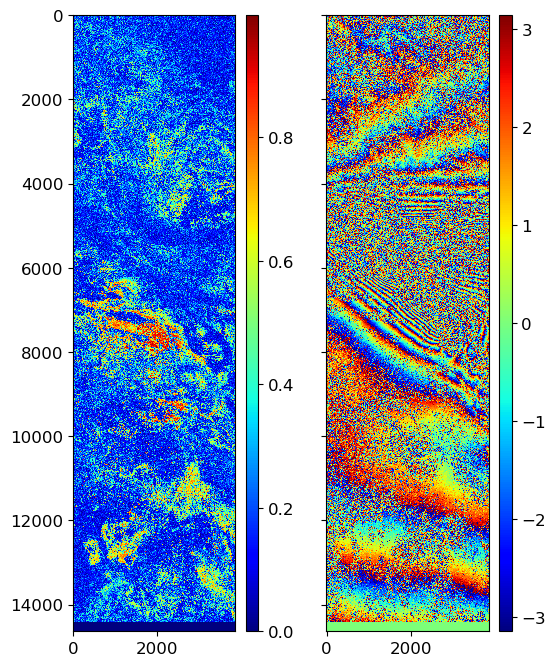

In [9]:
# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[6, 8], sharey=True)
for ax, data in zip(axs, [coh, pha]):
    im = ax.imshow(data, cmap='jet', interpolation='nearest')
    fig.colorbar(im, ax=ax, aspect=50)
plt.show()

In [10]:
# prepare metadata
meta = dict(atr)
meta['LENGTH'] = coh.shape[0]
meta['WIDTH'] = coh.shape[1]
meta['BANDS'] = '1'
meta['DATA_TYPE'] = 'complex64'
meta['BYTE_ORDER'] = 'little-endian'
meta['FILE_TYPE'] = '.int'
meta['PROCESSOR'] = 'isce'

# prepare int data
out_file = os.path.join(work_dir, 'fine.int')
int_data = coh * np.exp(-1j * pha)
writefile.write_isce_file(int_data, out_file=out_file, file_type='isce_int')
writefile.write_roipac_rsc(meta, out_file+'.rsc')

write file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/fine.int.xml
write file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/fine.int.vrt


'/home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/fine.int.rsc'

#### 1.2 Run filtering again to improve the coherence

In [12]:
# filter interferogram
in_file = os.path.join(work_dir, 'fine.int')
out_file = os.path.join(work_dir, 'filt_fine.int')
filter_goldstein(in_file, out_file, filt_strength=0.5)
writefile.write_roipac_rsc(meta, out_file+'.rsc')

# estimate coherence
isce_utils.estimate_coherence(int_file, cor_file)

Applying power-spectral filter
GDAL open (R): /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/fine.int.vrt
2023-06-24 20:50:10,289 - isce.mroipac.filter - DEBUG - width: 3854
API open (WR): /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int
2023-06-24 20:50:10,290 - isce.mroipac.filter - DEBUG - length: 14632
2023-06-24 20:50:10,291 - isce.mroipac.filter - DEBUG - input: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/fine.int
2023-06-24 20:50:10,292 - isce.mroipac.filter - DEBUG - output: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int
2023-06-24 20:50:10,292 - isce.mroipac.filter - DEBUG - filter strength: 0.5
2023-06-24 20:50:10,293 - isce.mroipac.filter - INFO - Filtering interferogram


line: 14631

array width, height, offset:  3854 14632     0

number of lines written to file: 14640
Rescaling magnitude
GDAL close: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/fine.int.vrt
API close:  /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int
GDAL open (R): /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int.vrt
API open (WR): /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.cor

 << PS filtering >>


 interferogram width:  3854  number of lines/patch:  3700
 start line:        1  number of lines:   14632
 start sample:      1  end sample:         3854
 wisdomFile, length =            0

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  5



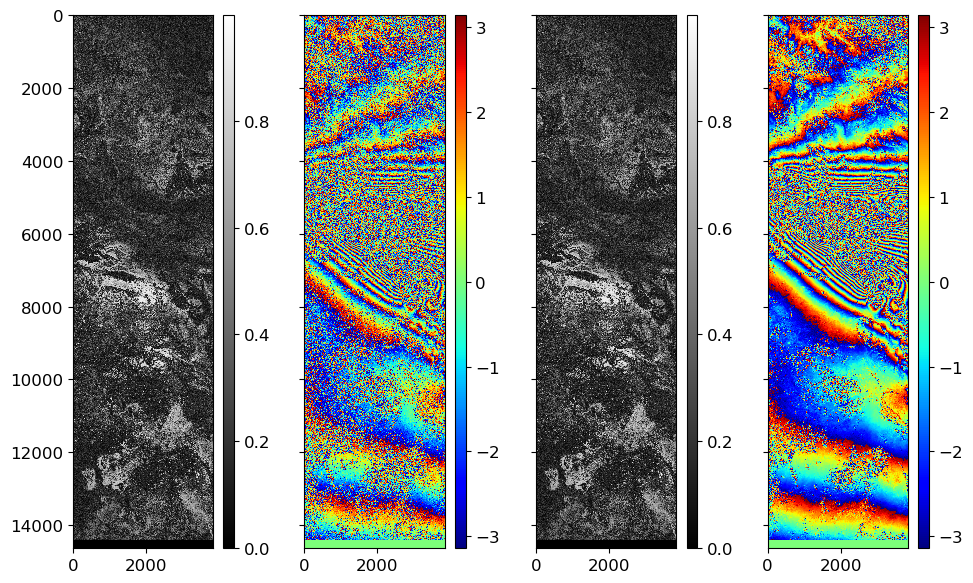

In [13]:
# plot
data_list = []
for fname in ['fine.int', 'filt_fine.int']:
    for ds_name in ['magnitude', 'phase']:
        data = readfile.read(fname, datasetName=ds_name)[0]
        data_list.append(data)
# plot
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=[10, 6], sharey=True)
for ax, data, cmap in zip(axs, data_list, ['gray', 'jet', 'gray', 'jet']):
    im = ax.imshow(data, cmap=cmap, interpolation='nearest')
    fig.colorbar(im, ax=ax, aspect=50)
fig.tight_layout()
plt.show()

### 2. Prepare geometry

create directory: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/inputs
create HDF5 file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/inputs/geometryGeo.h5 with w mode
create dataset /rangeCoord         of float32    in size of (16184, 8445)        with compression=None
create dataset /azimuthCoord       of float32    in size of (16184, 8445)        with compression=None
create dataset /height             of float32    in size of (16184, 8445)        with compression=None
create dataset /incidenceAngle     of float32    in size of (16184, 8445)        with compression=None
create dataset /azimuthAngle       of float32    in size of (16184, 8445)        with compression=None
create dataset /slantRangeDistance of float32    in size of (16184, 8445)        with compression=None
finished writing to /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/inputs/geometryGeo.h5
write file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/los.geo.xml
wri

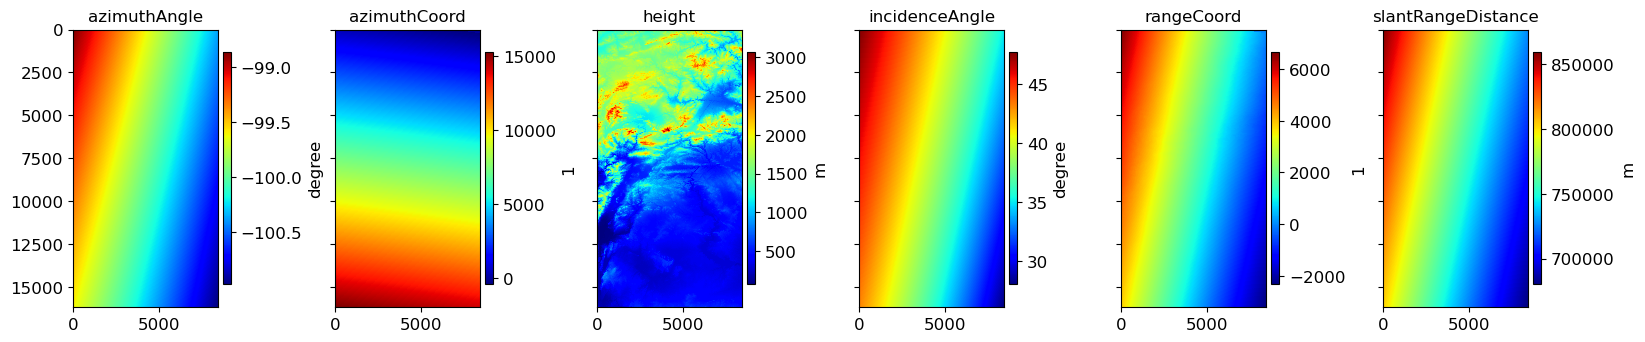

In [18]:
dem_atr_file = os.path.join(data_dir, 'dem/SRTM_ImagePart.dem_par')
atr = readfile.read_attribute(lut_file)

## read range / azimuth coordinates
lut_file = os.path.join(data_dir, 'dem/lookup_table.eqa_2_rdc')
# prepare RSC file
atr['BANDS'] = '2'
atr['INTERLEAVE'] = 'BIP'
atr['DATA_TYPE'] = 'float32'
atr['BYTE_ORDER'] = 'big-endian'
writefile.write_roipac_rsc(atr, lut_file+'.rsc')
# read data
rg_coord = readfile.read(lut_file, datasetName='rangeCoord')[0].astype(np.float32)
az_coord = readfile.read(lut_file, datasetName='azimuthCoord')[0].astype(np.float32)
## correct for extra offset in the lookup table, due to the cropping in step 1
#az_coord -= 157

## read height
hgt_file = os.path.join(data_dir, 'dem/SRTM_ImagePart.dem')
# prepare RSC file
if not os.path.isfile(hgt_file+'.par'):
    shutil.copyfile(hgt_file+'_par', hgt_file+'.par')
# read data
hgt = readfile.read(hgt_file)[0]

## read incidence / azimuth angle
inc_angle_file = os.path.join(data_dir, 'dem/lv_theta')
az_angle_file = os.path.join(data_dir, 'dem/lv_phi')
# prepare RSC file
atr['BANDS'] = '1'
writefile.write_roipac_rsc(atr, inc_angle_file+'.rsc')
writefile.write_roipac_rsc(atr, az_angle_file+'.rsc')
# read data
inc_angle = readfile.read(inc_angle_file)[0]
az_angle = readfile.read(az_angle_file)[0]
# convert from gamma to mintpy/isce2 convention
inc_angle = 90 - np.rad2deg(inc_angle)
az_angle = np.rad2deg(az_angle) - 90
az_angle = ut.wrap(az_angle, wrap_range=[-180, 180])

# calc slant range distance
atr = readfile.read_roipac_rsc(meta_file)
rg_dist = ut.incidence_angle2slant_range_distance(atr, inc_angle)

# write to geometryGeo.h5
ds_dict = {
    'rangeCoord'         : np.array(rg_coord, dtype=np.float32),
    'azimuthCoord'       : np.array(az_coord, dtype=np.float32),
    'height'             : np.array(hgt, dtype=np.float32),
    'incidenceAngle'     : np.array(inc_angle, dtype=np.float32),
    'azimuthAngle'       : np.array(az_angle, dtype=np.float32),
    'slantRangeDistance' : np.array(rg_dist, dtype=np.float32),
}
atr = readfile.read_attribute(lut_file)
atr['FILE_TYPE'] = 'geometry'
atr['LENGTH'] = hgt.shape[0]
atr['WIDTH'] = hgt.shape[1]
atr['DATA_TYPE'] = 'float32'
atr['BYTE_ORDER'] = 'little-endian'
atr['X_UNIT'] = 'degrees'
atr['Y_UNIT'] = 'degrees'
for key in ['BANDS', 'INTERLEAVE']:
    if key in list(atr.keys()):
        atr.pop(key)
writefile.write(ds_dict, out_file=geom_file, metadata=atr)

# write to los.geo file
out_file = os.path.join(work_dir, 'los.geo')
data = np.hstack((inc_angle, az_angle), dtype=np.float32)
atr['BANDS'] = '2'
atr['INTERLEAVE'] = 'BIL'
writefile.write_isce_xml(atr, out_file)
writefile.write_roipac_rsc(atr, out_file=out_file+'.rsc')
print(f'write file: {out_file}')
data.tofile(out_file)

# plot
view.main(f'{geom_file} --figsize 15 5 --noverbose'.split())

### 3. Phase unwrap

#### 3.1 Generate mask for EQ ruptures

Go to directory: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210
read fault lat/lon from file: /home/yunjunz/data/2023TurkeyEQ/USGS/simple_fault_confident.lonlat
read fault lat/lon from file: /home/yunjunz/data/2023TurkeyEQ/USGS/simple_fault_queried.lonlat
translating lat/lon into local X/Y coordiantes...
[==================================================] fault 33/33 (8 points)    3s /     0ss 
rasterize local X/Y coordiantes with a width of 20 pixels
write file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.msk
write file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.msk.rsc
write mask to file: /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.msk
descending orbit -> flip left-right


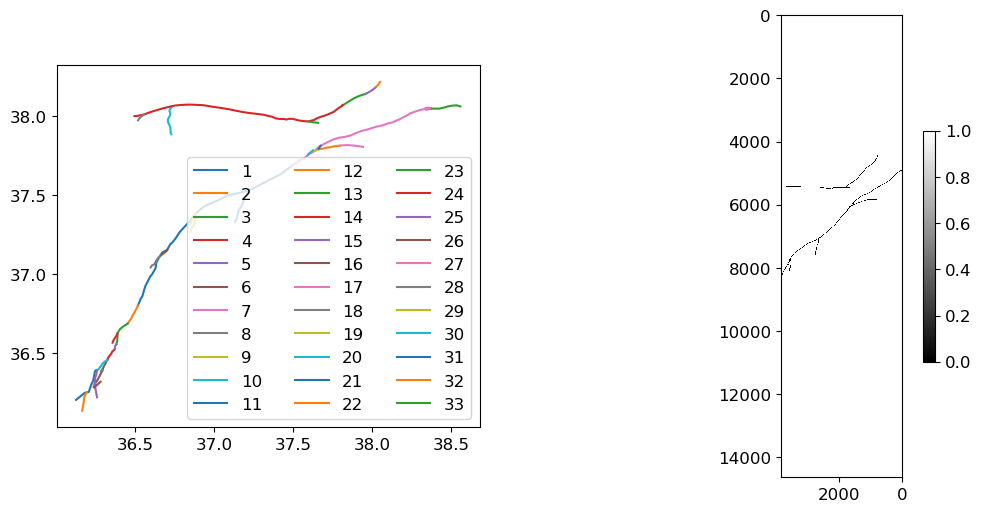

'/home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.msk'

In [23]:
gmt_lonlat_files = [os.path.join(proj_dir, f'USGS/simple_fault_{x}.lonlat') for x in ['confident', 'queried']]
generate_mask4earthquake_rupture(gmt_lonlat_files, int_file=int_file, msk_file=msk_file, lookup_file=geom_file, ymax=1e4)

#### 3.2 Re-run `unwrap.py`

In [24]:
# prepare metadata in ROIPAC format [in addition to the existing ISCE format]
meta = readfile.read_roipac_rsc(int_file+'.rsc')
meta['BANDS'] = '2'
meta['DATA_TYPE'] = 'float32'
meta['FILE_TYPE'] = '.unw'
writefile.write_roipac_rsc(meta, unw_file+'.rsc')

# run unwrap in screen mode
print(f'cd {work_dir}')
print(f'screen -S {dname.split("_")[1]}_UNW -L\nload_insar')
cmd = f'unwrap.py -i {int_file} -c {cor_file} -o {unw_file} --mask {msk_file} '
cmd += '--comp-max 20 --defo-max 10 --init-only --init-method MCF --cost-mode DEFO '
print(cmd)

cd /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210
screen -S D068_UNW -L
load_insar
unwrap.py -i /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.int -c /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.cor -o /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.unw --mask /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/filt_fine.msk --comp-max 20 --defo-max 10 --init-only --init-method MCF --cost-mode DEFO 


#### 3.3 Correct Unwrapping Error

Unwrapping errors are expected between the two sides of the Mw 7.8 rupture, as the rupture traces went throughout the images, cutting it into 2 parts. A manual correction is applied below to stitch the two, assuming the phase difference betwen far sides of the two parts from LT1 is similar to ALOS2_D077.

remove regions with area < 2500
phase difference between two parts in ALOS2_D077: -2.6 rad
phase difference between two parts in LT1_D068: 114.0 rad
number of cycles to be corrected: -19.0
save figure to file /scratch/yunjunz/2023TurkeyEQ/LT1_D068_20220411_20230210/unw_err_corr.png


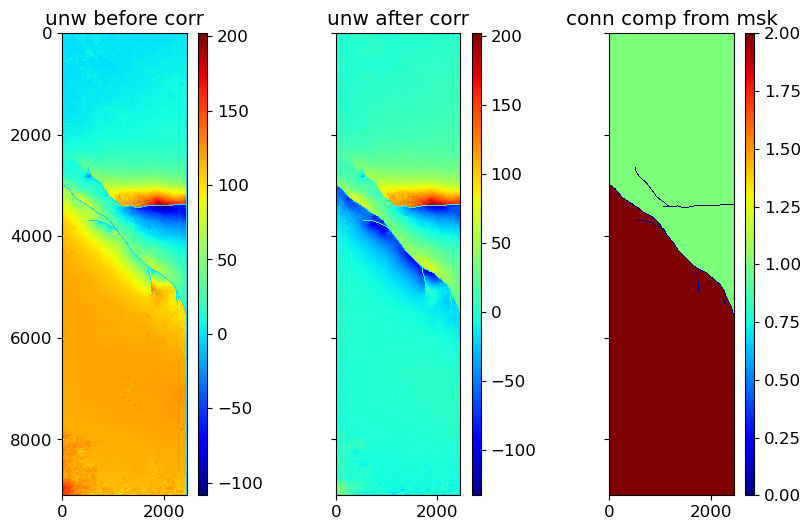

In [176]:
# read the data
unw, atr = readfile.read('./filt_fine.unw')
# flip the sign of the Gamma product, to be consistent with ALOS-2 result from ISCE-2.
unw *= -1

# estimate PU error
msk = readfile.read('./filt_fine.msk')[0]
label_img = conncomp.label_conn_comp(msk, min_area=2.5e3, erosion_size=0, print_msg=True)[0]

lat1, lon1 = 38.8, 37.5
lat2, lon2 = 36.5, 37.0

# phase difference in reference file: ALOS2_D077
ref_unw_file = os.path.join(proj_dir, 'ALOS2_D077_20220916_20230217/insar/geo/geo_filt_msk.unw')
ref_unw, ref_atr = readfile.read(ref_unw_file, datasetName='phase')
ref_coord = ut.coordinate(ref_atr)
ry1, rx1 = ref_coord.geo2radar(lat1, lon1)[:2]
ry2, rx2 = ref_coord.geo2radar(lat2, lon2)[:2]
# phase difference
ref_diff_value = np.nanmedian(ref_unw[ry2-50:ry2+50, rx2-50:rx2+50]) - np.nanmedian(ref_unw[ry1-50:ry1+50, rx1-50:rx1+50])
print(f'phase difference between two parts in ALOS2_D077: {ref_diff_value:.1f} rad')

# phase difference in LT1
coord = ut.coordinate(atr, lookup_file=geom_file)
y1, x1 = coord.geo2radar(lat1, lon1)[:2]
y2, x2 = coord.geo2radar(lat2, lon2)[:2]
diff_value = np.nanmedian(unw[y2-50:y2+50, x2-50:x2+50]) - np.nanmedian(unw[y1-50:y1+50, x1-50:x1+50])
print(f'phase difference between two parts in LT1_D068: {diff_value:.1f} rad')

# estimate phase jumps
diff_value -= ref_diff_value
num_jump = (np.abs(diff_value) + np.pi) // (2.*np.pi)
if diff_value > 0:
    num_jump *= -1
print(f'number of cycles to be corrected: {num_jump}')

# correct PU error
unw_cor = np.array(unw, dtype=np.float32)
unw_cor[label_img == 2] += num_jump * 2 * np.pi

# plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[10, 6], sharey=True)
for ax, data, title in zip(axs, [unw, unw_cor, label_img], ['unw before corr', 'unw after corr', 'conn comp from msk']):
    im = ax.imshow(data, cmap='jet', interpolation='nearest')
    ax.set_title(title)
    fig.colorbar(im, ax=ax, aspect=50)
# output
out_fig = os.path.abspath('unw_err_corr.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

In [133]:
# write to file
out_file = './filt_fine_cor.unw'
# metadata
atr['BANDS'] = '2'
atr['INTERLEAVE'] = 'BIL'
atr['DATA_TYPE'] = 'float32'
writefile.write_isce_xml(atr, fname=out_file)
writefile.write_roipac_rsc(atr, out_file=out_file+'.rsc')
# binary
amp = readfile.read('./filt_fine.unw', datasetName='magnitude')[0]
data = np.hstack((amp, unw_cor), dtype=np.float32).flatten()
print(f'write file: {out_file}')
data.tofile(out_file)

write file: ./filt_fine_cor.unw.xml
write file: ./filt_fine_cor.unw.vrt
write file: ./filt_fine_cor.unw


### 4. Mask + Geocode

In [134]:
fbase = 'filt_fine'
mask.main(f'{fbase}_cor.unw -m {fbase}.unw.conncomp'.split())

cmd = f'{fbase}.int {fbase}.cor {fbase}_cor_msk.unw -l {geom_file} --fill nan'
print(f'geocode.py {cmd}')
geocode.main(cmd.split())

masking magnitude from filt_fine_cor.unw ...
masking phase     from filt_fine_cor.unw ...
write file: filt_fine_cor_msk.unw
write file: filt_fine_cor_msk.unw.rsc
geocode.py filt_fine.int filt_fine.cor filt_fine_cor_msk.unw -l /home/yunjunz/data/2023TurkeyEQ/LT1_D068_20220411_20230210/inputs/geometryGeo.h5 --fill nan
number of processor to be used: 1
resampling software: pyresample
output pixel size in (lat, lon) in degree: (-0.00027777778, 0.00027777778)
output area extent in (S, N, W, E) in degree: (34.800833284759996, 39.4836111, 36.2488889, 38.63972225246)
--------------------------------------------------
resampling file: filt_fine.int
--------------------------------------------------1/1
reading complex in block (0, 0, 2452, 9100) from filt_fine.int ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 146 segments ...
write file: geo_filt_fine.int
write file: geo_filt_fine.int.rsc
--------------------------------------------------
resampling file: filt_fine.cor
----

run view.py in MintPy version 1.5.1.post47, date 2023-06-21
input file is isce .unw file: /scratch/yunjunz/2023TurkeyEQ/LT1_D068_20220411_20230210/geo_filt_fine_cor_msk.unw in float32 format
file size in y/x: (16858, 8607)
input dataset: "['phase']"
num of datasets in file geo_filt_fine_cor_msk.unw: 2
datasets to exclude (0):
[]
datasets to display (1):
['phase']
data   coverage in y/x: (0, 0, 8607, 16858)
subset coverage in y/x: (0, 1741, 8607, 15061)
data   coverage in lat/lon: (36.2488889, 39.4836111, 38.63972225246, 34.800833284759996)
subset coverage in lat/lon: (36.2488889, 38.99999998502, 38.63972225246, 35.29999995542)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: LT1_D068_20220411_20230210_IFG
figure size : [6.00, 7.43]
reading data ...
Apply math operation: reverse
data    range: [-2.475969, 3.8123715] m
display ran

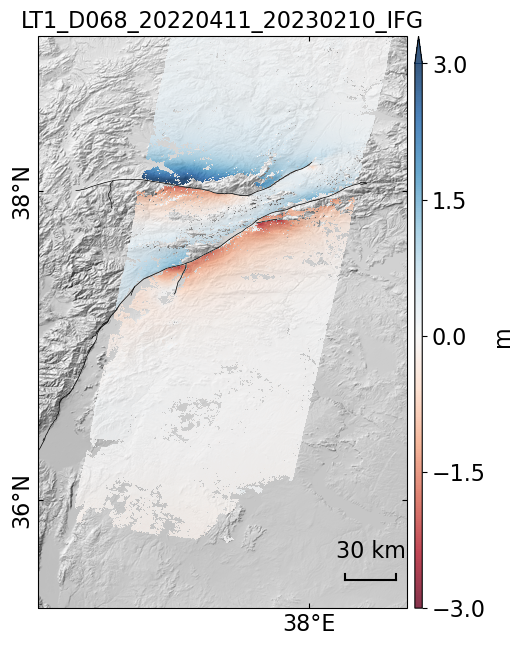

In [167]:
# plot
unw_file = 'geo_filt_fine_cor_msk.unw'
dem_file = os.path.join(proj_dir, 'DEM/demLat_N35_N42_Lon_E034_E041_90m.h5')
out_file = os.path.join(proj_dir, f'notebooks/docs/{dname}_IFG.png')
cmd = f'{unw_file} phase --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} '
cmd += f'-c RdBu -v -3 3 -u m --lalo-label --lalo-step 2 --ylabel-rot 90 --cbar-nbins 5 '
cmd += f'--scalebar 0.12 0.90 0.05 --title {dname}_IFG --ref-size 4 --math reverse '
cmd += '--sub-lat 35.3 39.0 '
cmd += f'-o {out_file} '
view.main(cmd.split())

### 5. Correct for troposphere & solid Earth tides

In [169]:
!tropo_pyaps3.py -f ./geo_filt_fine_cor_msk.unw -g ./inputs/geometryGeo.h5

weather model: ERA5 - dry (hydrostatic) and wet delay
weather directory: /home/yunjunz/data/aux
output tropospheric delay     time-series file: ./inputs/ERA5.h5
output corrected displacement time-series file: ./geo_filt_fine_cor_msk_ERA5.unw
read dates/time info from file: ./geo_filt_fine_cor_msk.unw
time of cloest available product: 04:00 UTC

--------------------------------------------------------------------------------
Download global atmospheric model files...
update mode: ON
output file: ./inputs/ERA5.h5
1) output file exists and is newer than all GRIB files.
2) output file does NOT have the same len/wid as the geometry file ./inputs/geometryGeo.h5 or does NOT contain all dates
run or skip: run
--------------------------------------------------
downloading weather model data using PyAPS ...
common file size: 1478520 bytes
number of grib files existed    : 2
number of grib files to download: 0
--------------------------------------------------

-----------------------------------

In [170]:
!solid_earth_tides.py ./geo_filt_fine_cor_msk_ERA5.unw -g ./inputs/geometryGeo.h5

prepare LOS geometry in geo-coordinates from file: ./inputs/geometryGeo.h5
read incidenceAngle from file: ./inputs/geometryGeo.h5
read azimuthAngle   from file: ./inputs/geometryGeo.h5
get the unit vector for enu2los projection with mean value: E = 0.617, N = -0.108, U = 0.776.

--------------------------------------------------
calculating solid Earth tides using PySolid (Milbert, 2018; Yunjun et al., 2022) ...
[==================================================] 2023-02-10T03:34:29.520322 (2/2)   13s /    13s
create HDF5 file: ./inputs/SET.h5 with w mode
create dataset /timeseries of float32    in size of (2, 16858, 8607)     with compression=None
create dataset /date       of |S8        in size of (2,)                 with compression=None
create dataset /sensingMid of |S15       in size of (2,)                 with compression=None
finished writing to ./inputs/SET.h5
correcting tide for using diff.py
diff.py ./geo_filt_fine_cor_msk_ERA5.unw ./inputs/SET.h5 -o ./geo_filt_fine_cor_ms

### 6. Subset

Subset to the same size as the rest datasets.

In [173]:
S, N, W, E = 35.3, 39.0, 35.0, 39.5   # same as Fig. 1
for fname in ['geo_filt_fine_cor_msk_ERA5_SET.unw', 'geo_filt_fine.cor', 'los.geo']:
    out_file = f'./sub/{fname}'
    cmd = f'{fname} -o {out_file} --lat {S} {N} --lon {W} {E} --outfill nan'
    print(f'subset.py {cmd}')
    subset.main(cmd.split())
    # write isce metadata
    atr = readfile.read_attribute(out_file)
    writefile.write_isce_xml(atr, out_file)

subset.py geo_filt_fine_cor_msk_ERA5_SET.unw -o ./sub/geo_filt_fine_cor_msk_ERA5_SET.unw --lat 35.3 39.0 --lon 35.0 39.5 --outfill nan
------------------------------
subset .unw file: geo_filt_fine_cor_msk_ERA5_SET.unw ...
data   range in (x0,y0,x1,y1): (0, 0, 8607, 16858)
subset range in (x0,y0,x1,y1): (-4496, 1741, 11704, 15061)
data   range in (W, N, E, S): (36.2488889, 39.4836111, 38.63972225246, 34.800833284759996)
subset range in (W, N, E, S): (35.00000000112, 38.99999998502, 39.500000037119996, 35.29999995542)
writing >>> ./sub/geo_filt_fine_cor_msk_ERA5_SET.unw
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: -4496/1741/11704/15061
update Y/X_FIRST
reading magnitude in (0, 1741, 8607, 15061) from geo_filt_fine_cor_msk_ERA5_SET.unw ...
reading phase in (0, 1741, 8607, 15061) from geo_filt_fine_cor_msk_ERA5_SET.unw ...
write file: ./sub/geo_filt_fine_cor_msk_ERA5_SET.unw
write file: ./sub/geo_filt_fine_cor_msk_ERA5_SET.unw.rsc
write file: ./sub/geo_filt_fine_co

#### 6.1 Quality check

In [174]:
# read LT1
pha, atr = readfile.read('./sub/geo_filt_fine_cor_msk_ERA5_SET.unw', datasetName='phase')

# read ALOS2
ref_unw_file = os.path.join(proj_dir, 'ALOS2_D077_20220916_20230217/insar/geo/geo_filt_msk.unw')
ref_pha0, ref_atr = readfile.read(ref_unw_file, datasetName='phase')
ref_pha = resize(np.array(ref_pha0), pha.shape, order=1, mode='constant', anti_aliasing=True, preserve_range=True)

# calc the difference
pha_diff = pha - ref_pha
pha_diff -= np.nanmedian(pha_diff)

/home/yunjunz/tools/mambaforge/envs/insar/lib/python3.11/site-packages/skimage/transform/_warps.py:674: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/yunjunz/tools/mambaforge/envs/insar/lib/python3.11/site-packages/skimage/transform/_warps.py:678: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


save figure to file /scratch/yunjunz/2023TurkeyEQ/LT1_D068_20220411_20230210/lt1_vs_alos2.png


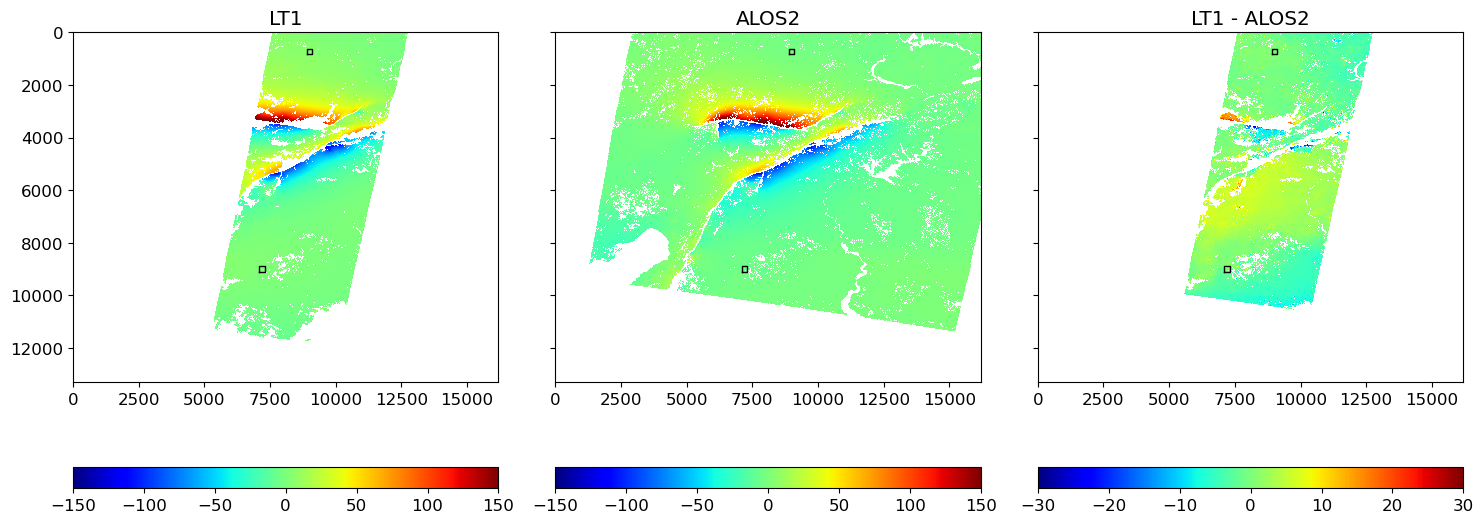

In [175]:
coord = ut.coordinate(atr)
yx1 = coord.geo2radar(lat1, lon1)[:2]
yx2 = coord.geo2radar(lat2, lon2)[:2]
buff = 100

# plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 6], sharey=True)
for ax, data, title, vmax in zip(axs, [pha, ref_pha, pha_diff], ['LT1', 'ALOS2', 'LT1 - ALOS2'], [150, 150, 30]):
    im = ax.imshow(data, vmin=-vmax, vmax=vmax, cmap='jet', interpolation='nearest')
    ax.set_title(title)
    fig.colorbar(im, ax=ax, orientation='horizontal')
    # plot reference region
    for y, x in [yx1, yx2]:
        xs = [x-buff, x+buff, x+buff, x-buff, x-buff]
        ys = [y+buff, y+buff, y-buff, y-buff, y+buff]
        ax.plot(xs, ys, 'k-', lw=1)
fig.tight_layout()

# output
out_fig = os.path.abspath('lt1_vs_alos2.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Plot

run view.py in MintPy version 1.5.1.post47, date 2023-06-21
input file is isce .unw file: /scratch/yunjunz/2023TurkeyEQ/LT1_D068_20220411_20230210/sub/geo_filt_fine_cor_msk_ERA5_SET.unw in float32 format
file size in y/x: (13320, 16200)
input dataset: "['phase']"
num of datasets in file geo_filt_fine_cor_msk_ERA5_SET.unw: 2
datasets to exclude (0):
[]
datasets to display (1):
['phase']
data   coverage in y/x: (0, 0, 16200, 13320)
subset coverage in y/x: (0, 0, 16200, 13320)
data   coverage in lat/lon: (35.00000000112, 38.99999998502, 39.50000003712, 35.29999995542)
subset coverage in lat/lon: (35.00000000112, 38.99999998502, 39.50000003712, 35.29999995542)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: LT1_D068_20220411_20230210_IFG
figure size : [9.12, 6.00]
reading data ...
Apply math operation: reverse
data    range: [-2.48

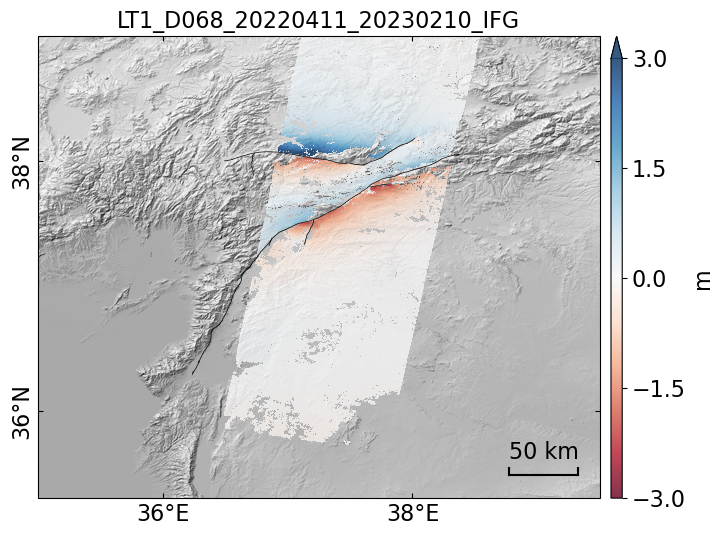

In [177]:
# plot
unw_file = './sub/geo_filt_fine_cor_msk_ERA5_SET.unw'
dem_file = os.path.join(proj_dir, 'DEM/demLat_N35_N42_Lon_E034_E041_90m.h5')
out_file = os.path.join(proj_dir, f'notebooks/docs/{dname}_IFG.png')
cmd = f'{unw_file} phase --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} '
cmd += f'-c RdBu -v -3 3 -u m --lalo-label --lalo-step 2 --ylabel-rot 90 --cbar-nbins 5 '
cmd += f'--scalebar 0.12 0.90 0.05 --title {dname}_IFG --ref-size 4 --math reverse '
cmd += f'-o {out_file} '
view.main(cmd.split())

### Backup: get bperp

P_BASELINE_BOTTOM_HDR: -564.51 m
P_BASELINE_TOP_HDR: -542.05 m


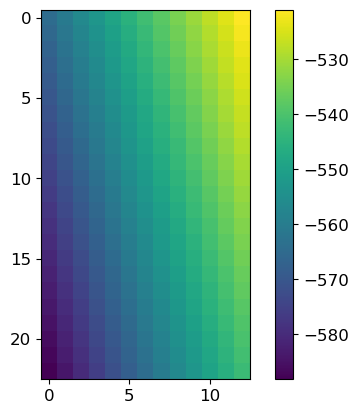

In [130]:
# read perp_baseline
bperp_file = os.path.join(data_dir, 'B_A.bperp')
num_row = int(11000 / 500 + 1)
num_col = int(2400 / 200 + 1)
bperp = np.loadtxt(bperp_file, usecols=[7], skiprows=12, max_rows=299).reshape(num_row, num_col)

print(f'P_BASELINE_BOTTOM_HDR: {np.mean(bperp[-1,:]):.2f} m')
print(f'P_BASELINE_TOP_HDR: {np.mean(bperp[0,:]):.2f} m')

# plot
plt.figure()
plt.imshow(bperp)
plt.colorbar()
plt.show()